# Coding Requirements

1. Choose a dataset that has an outcome (predictive) variable.
2. Split that into train and test.
3. Define a metric to evaluate a machine learning model.
4. Build a pipeline using Airflow or MLflow or your platform pipeline to train a machine learning model using the train dataset (use AutoML to refine the category of algorithms).
5. Deploy the model for inference.
6. Set up model monitoring (if there is a monitoring dashboard show that).
7. Use the test data with the deployed model and validate the results (metric) and model monitoring.
8. Change atleast 2 feature values of the test dataset (you can put in random values or swap 2 features).
9. Use the "changed" test data with the deployed model and validate the results (metric) and verify observation with model monitoring.

# Presentation Requirements

Presentation in class that covers the above points with a video demo of #7 and #9.
The presentation PPT should include

1. EDA of your chosen dataset
2. Metric to evaluate the machine learning model
3. Pipeline you used to train the machine learning model
4. AutoML results and the chosen algorithm
5. Model monitoring
6. The "change" in the test dataset
7. Github link that contains the project code

Clearly outline which member did which part of the project.

Data Available at: https://www.kaggle.com/datasets/muhammadroshaanriaz/time-wasters-on-social-media/data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import kagglehub
import shutil
import os
import glob
import pandas as pd
from pprint import pprint as pp

# Downloading the data from kaggle
path = kagglehub.dataset_download("muhammadroshaanriaz/time-wasters-on-social-media")

os.makedirs('./data', exist_ok=True)
if os.path.isdir(path):
    files = glob.glob(os.path.join(path, '**'), recursive=True)
    for file in files:
        if os.path.isfile(file): 
            shutil.move(file, './data')
else:
    shutil.move(path, './data')
print("Path to dataset files:", './data')

df = pd.read_csv('./data/Time-Wasters on Social Media.csv')
print(f"Dataframe columns: {df.columns}")
df.head()

Path to dataset files: ./data
Dataframe columns: Index(['UserID', 'Age', 'Gender', 'Location', 'Income', 'Debt',
       'Owns Property', 'Profession', 'Demographics', 'Platform',
       'Total Time Spent', 'Number of Sessions', 'Video ID', 'Video Category',
       'Video Length', 'Engagement', 'Importance Score', 'Time Spent On Video',
       'Number of Videos Watched', 'Scroll Rate', 'Frequency',
       'ProductivityLoss', 'Satisfaction', 'Watch Reason', 'DeviceType', 'OS',
       'Watch Time', 'Self Control', 'Addiction Level', 'CurrentActivity',
       'ConnectionType'],
      dtype='object')


,UserID,Age,Gender,Location,Income,Debt,Owns Property,Profession,Demographics,Platform,...,ProductivityLoss,Satisfaction,Watch Reason,DeviceType,OS,Watch Time,Self Control,Addiction Level,CurrentActivity,ConnectionType
0,1,56,Male,Pakistan,82812,True,True,Engineer,Rural,Instagram,...,3,7,Procrastination,Smartphone,Android,9:00 PM,5,5,Commuting,Mobile Data
1,2,46,Female,Mexico,27999,False,True,Artist,Urban,Instagram,...,5,5,Habit,Computer,Android,5:00 PM,7,3,At school,Wi-Fi
2,3,32,Female,United States,42436,False,True,Engineer,Rural,Facebook,...,6,4,Entertainment,Tablet,Android,2:00 PM,8,2,At home,Mobile Data
3,4,60,Male,Barzil,62963,True,False,Waiting staff,Rural,YouTube,...,3,7,Habit,Smartphone,Android,9:00 PM,5,5,Commuting,Mobile Data
4,5,25,Male,Pakistan,22096,False,True,Manager,Urban,TikTok,...,8,2,Boredom,Smartphone,iOS,8:00 AM,10,0,At home,Mobile Data


# EDA

<Axes: >

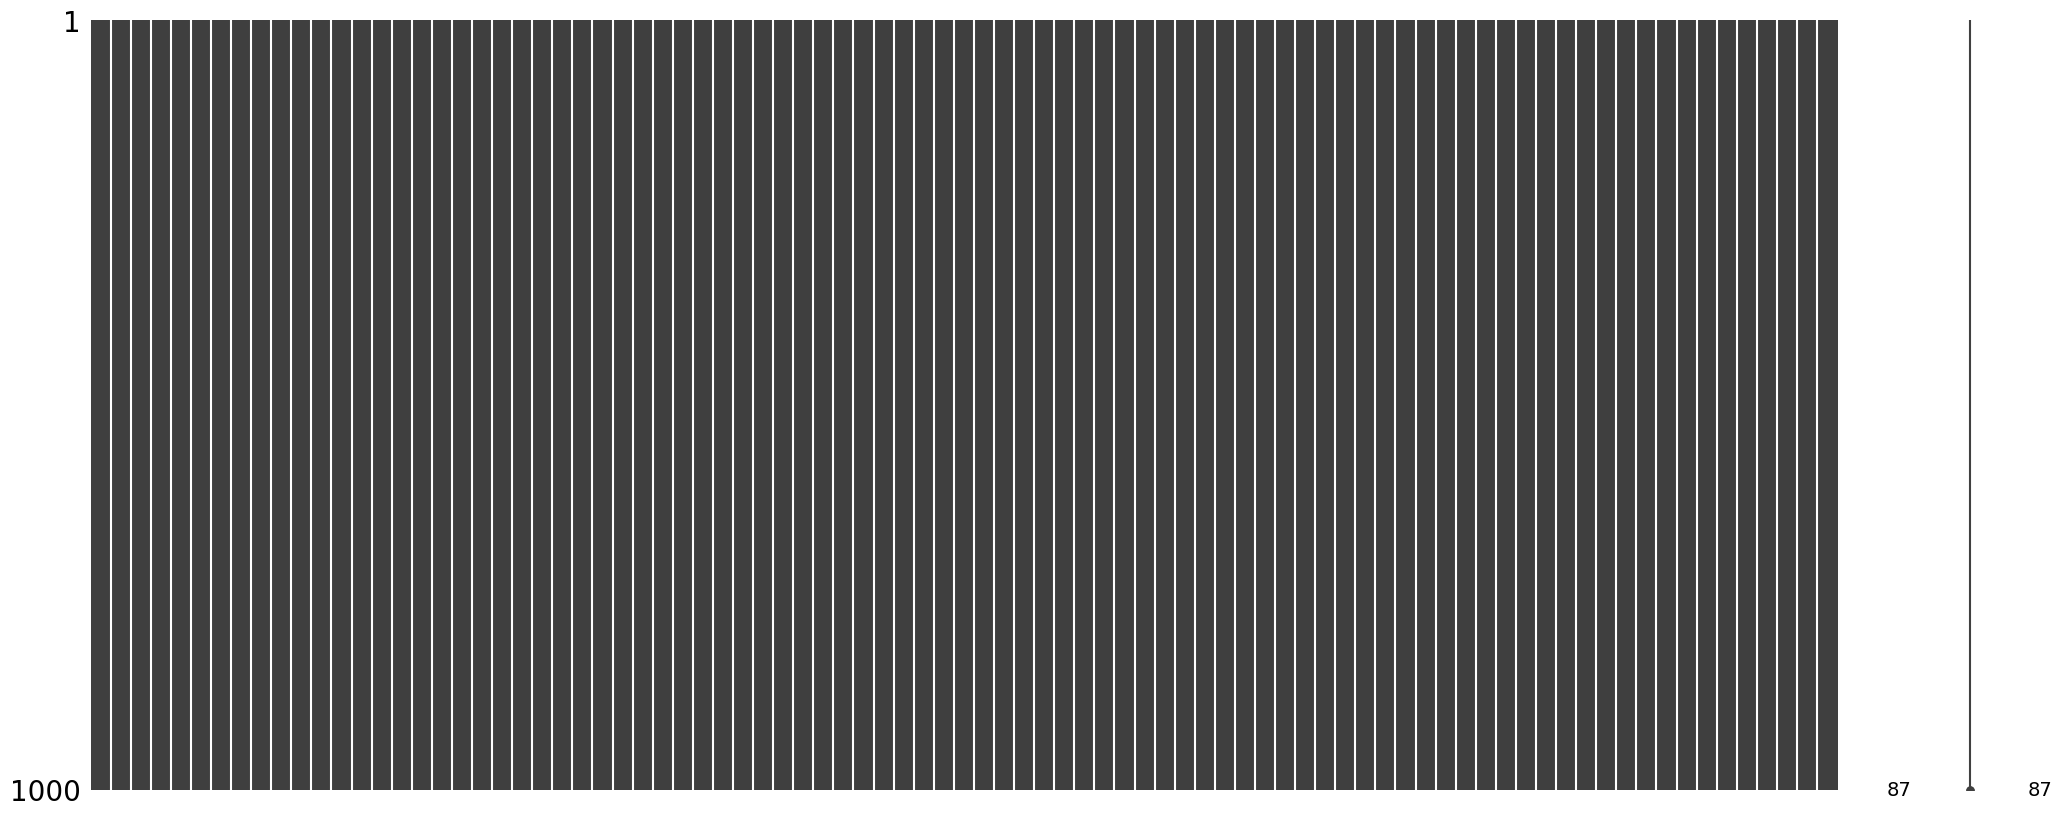

In [9]:
import missingno as msno

# Visualize the missing values in the dataframe
msno.matrix(df)

# Preprocessing

In [3]:
def good_one_hot(X, n_unique):

    X_copy = X.copy()  
    
    for col in X_copy.select_dtypes(include=['object', 'category']).columns:
        top_categories = X_copy[col].value_counts().nlargest(n_unique).index
        X_copy[col] = X_copy[col].where(X_copy[col].isin(top_categories), other="Other")
    
    X_encoded = pd.get_dummies(X_copy, columns=X_copy.select_dtypes(include=['object', 'category']).columns)
    
    return X_encoded

df = good_one_hot(df, 10)

y = df['ProductivityLoss']
x = df.drop(columns=['ProductivityLoss'])

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Add these to the data folder for the AutoML portion
train = pd.concat([x_train, y_train], axis=1)
test = pd.concat([x_test, y_test], axis=1)
train.to_csv('./data/train.csv', index=False)
test.to_csv('./data/test.csv', index=False)

# AutoML

Using AutoML to define what are some good model categories to try out

In [4]:
import h2o
from h2o.automl import H2OAutoML

h2o.init(port = 54325, nthreads = -1, max_mem_size = "6g")
train = h2o.import_file("data/train.csv")
test = h2o.import_file("data/test.csv")
x = train.columns
y = "ProductivityLoss"
x.remove(y)
train[y] = train[y].asnumeric()
test[y] = test[y].asnumeric()
aml = H2OAutoML(max_models=100, max_runtime_secs=60, seed=1) 
aml.train(x=x, y=y, training_frame=train)
lb = aml.leaderboard
lb.head(rows=lb.nrows)

Checking whether there is an H2O instance running at http://localhost:54325..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "21.0.1" 2023-10-17 LTS; OpenJDK Runtime Environment Temurin-21.0.1+12 (build 21.0.1+12-LTS); OpenJDK 64-Bit Server VM Temurin-21.0.1+12 (build 21.0.1+12-LTS, mixed mode)
  Starting server from /Users/zfara/Repositories/UChicago/MLOps/project/MLOps-UChicago-ADSP/.venv/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/fy/6nhb1jds74vcbb55n83td9ph0000gn/T/tmpp3r3da6j
  JVM stdout: /var/folders/fy/6nhb1jds74vcbb55n83td9ph0000gn/T/tmpp3r3da6j/h2o_zfara_started_from_python.out
  JVM stderr: /var/folders/fy/6nhb1jds74vcbb55n83td9ph0000gn/T/tmpp3r3da6j/h2o_zfara_started_from_python.err
  Server is running at http://127.0.0.1:54325
Connecting to H2O server at http://127.0.0.1:54325 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_zfara_e6df1c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.987 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
00:19:29.597: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_grid_1_AutoML_1_20241125_01929_model_5,0.0342232,0.00117123,0.00208576,0.00697738,0.00117123
GBM_3_AutoML_1_20241125_01929,0.0457771,0.00209554,0.0107368,0.0057599,0.00209554
GBM_grid_1_AutoML_1_20241125_01929_model_12,0.0471789,0.00222585,0.00626741,0.00585655,0.00222585
GBM_grid_1_AutoML_1_20241125_01929_model_2,0.0498467,0.00248469,0.00712468,0.00603645,0.00248469
GBM_2_AutoML_1_20241125_01929,0.0507635,0.00257694,0.011803,0.00635093,0.00257694
GBM_4_AutoML_1_20241125_01929,0.0532846,0.00283925,0.0158145,0.00706243,0.00283925
GBM_5_AutoML_1_20241125_01929,0.0650748,0.00423473,0.0106336,0.00856442,0.00423473
GBM_grid_1_AutoML_1_20241125_01929_model_7,0.0670995,0.00450234,0.0393641,0.0143293,0.00450234
DRF_1_AutoML_1_20241125_01929,0.0833766,0.00695166,0.0262339,0.0136362,0.00695166
GBM_grid_1_AutoML_1_20241125_01929_model_9,0.107339,0.0115217,0.0593082,0.0204664,0.0115217


In [5]:
# Display the top 5 models from the H2O AutoML leaderboard
lb.head(rows=25)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_grid_1_AutoML_1_20241125_01929_model_5,0.0342232,0.00117123,0.00208576,0.00697738,0.00117123
GBM_3_AutoML_1_20241125_01929,0.0457771,0.00209554,0.0107368,0.0057599,0.00209554
GBM_grid_1_AutoML_1_20241125_01929_model_12,0.0471789,0.00222585,0.00626741,0.00585655,0.00222585
GBM_grid_1_AutoML_1_20241125_01929_model_2,0.0498467,0.00248469,0.00712468,0.00603645,0.00248469
GBM_2_AutoML_1_20241125_01929,0.0507635,0.00257694,0.011803,0.00635093,0.00257694
GBM_4_AutoML_1_20241125_01929,0.0532846,0.00283925,0.0158145,0.00706243,0.00283925
GBM_5_AutoML_1_20241125_01929,0.0650748,0.00423473,0.0106336,0.00856442,0.00423473
GBM_grid_1_AutoML_1_20241125_01929_model_7,0.0670995,0.00450234,0.0393641,0.0143293,0.00450234
DRF_1_AutoML_1_20241125_01929,0.0833766,0.00695166,0.0262339,0.0136362,0.00695166
GBM_grid_1_AutoML_1_20241125_01929_model_9,0.107339,0.0115217,0.0593082,0.0204664,0.0115217


Now it seems the main model architectures are 
1. Gradient Boosting Trees
2. Deep Learning
3. Random Forest

# MLFlow
Now let's do the MLFlow sections

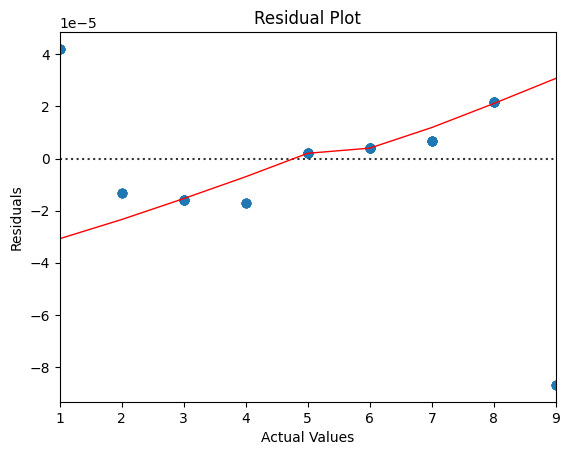

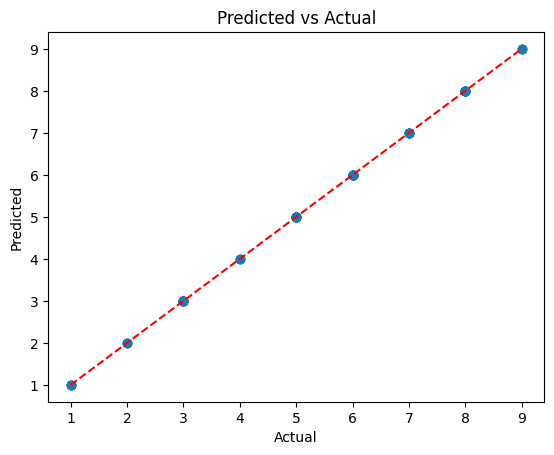

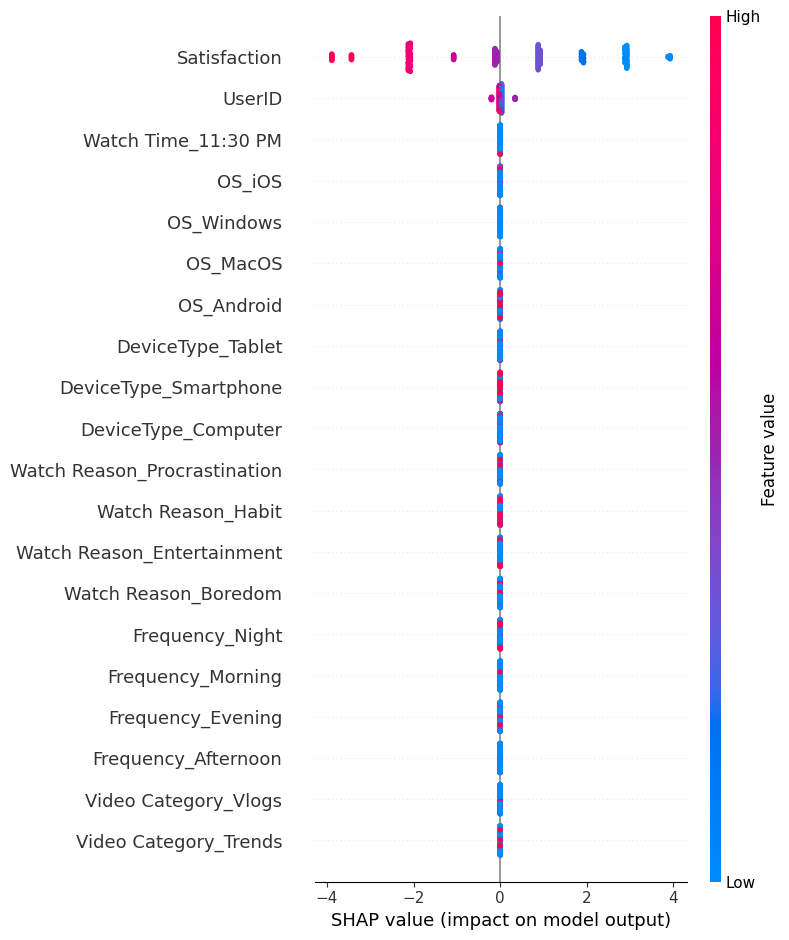

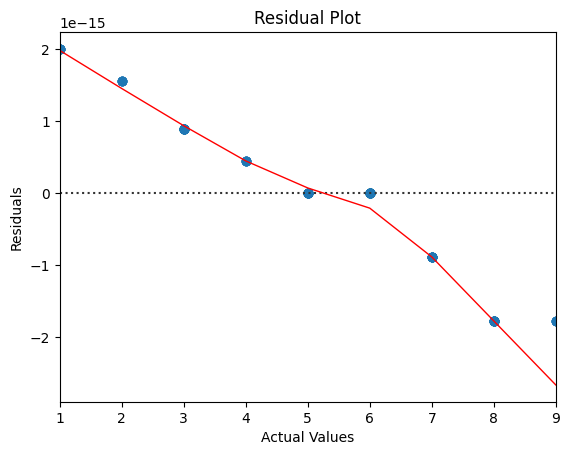

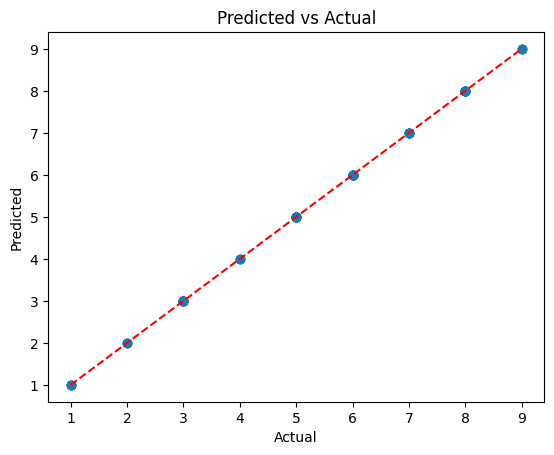

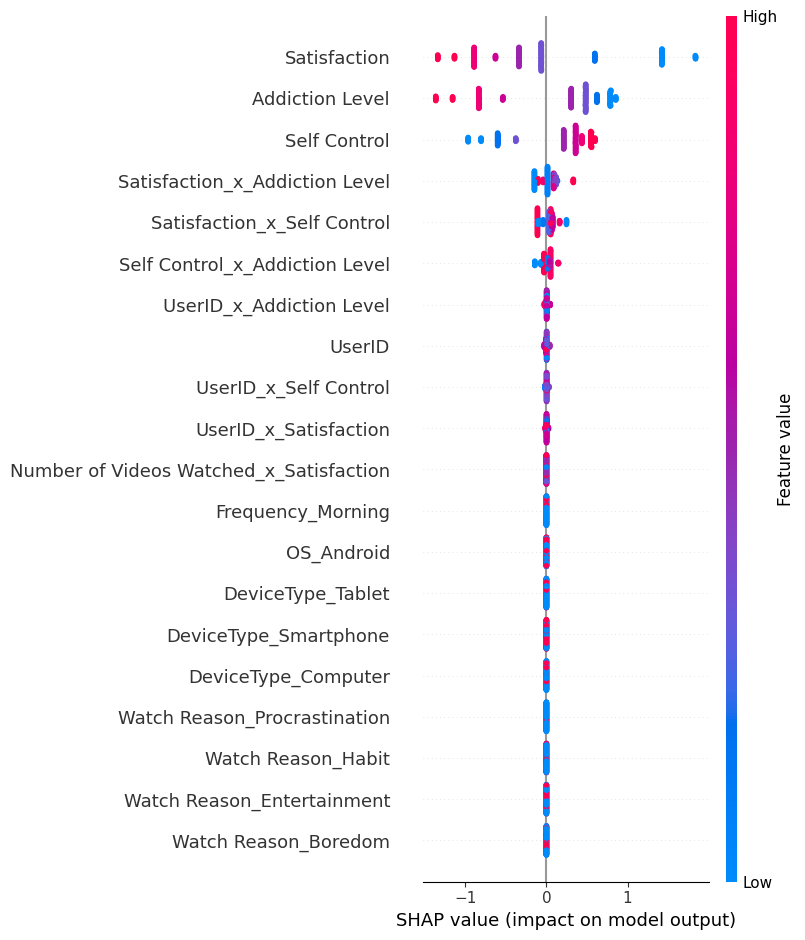

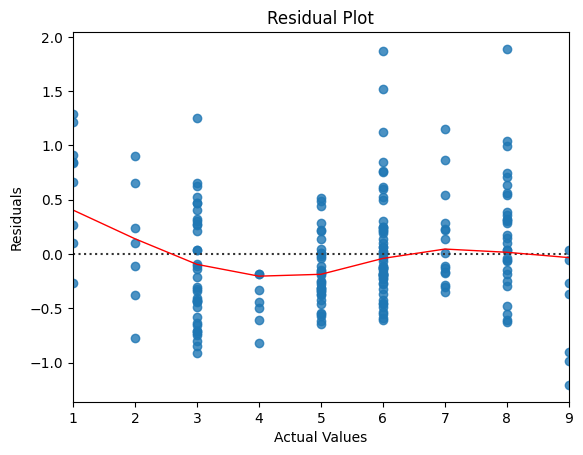

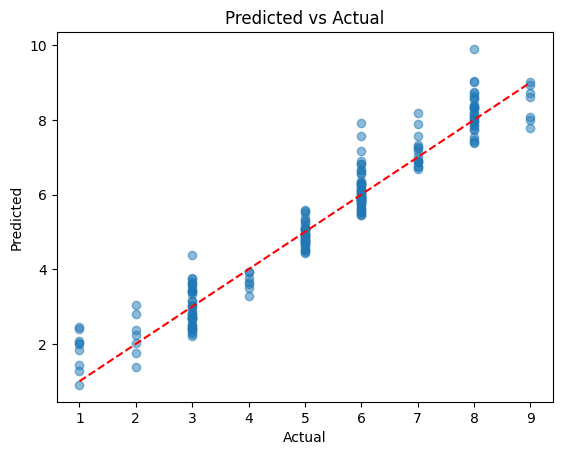

100%|██████████| 200/200 [01:34<00:00,  2.11it/s]


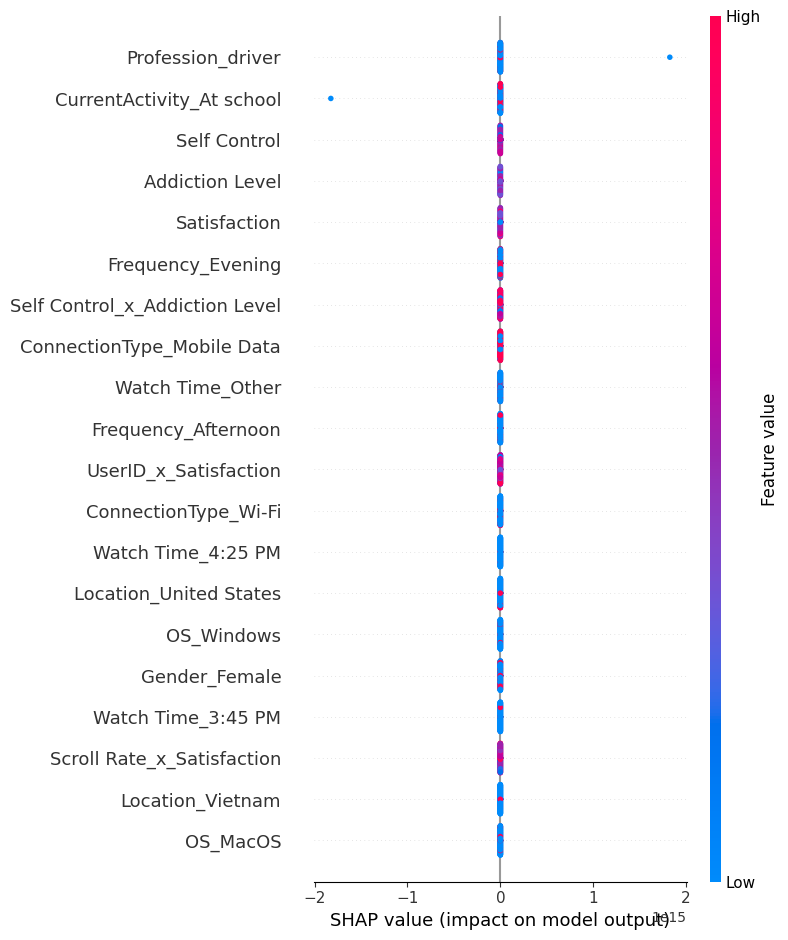

In [20]:
# Required imports
import seaborn as sns
import shap
import mlflow
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

mlflow.set_experiment("Flexible Model Experiment")

# Function to evaluate regression metrics
def regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return r2, rmse, mae, mse

# Function to add interaction terms
def add_interaction_terms(X):
    from itertools import combinations
    interaction_terms = pd.DataFrame(index=X.index)
    continuous_columns = X.select_dtypes(include=[np.number]).columns
    for col1, col2 in combinations(continuous_columns, 2):
        interaction_term_name = f"{col1}_x_{col2}"
        interaction_terms[interaction_term_name] = X[col1] * X[col2]
    return pd.concat([X, interaction_terms], axis=1)

# Flexible experiment runner
def run_experiment(features, target, model, hyperparams=None):
    # Preprocessing
    try:
        X = features.drop(columns=[target])
        y = features[target]
        
        X.fillna(X.mean(), inplace=True)  # For numeric columns

        # Scale continuous features
        scaler = StandardScaler()
        continuous_columns = X.select_dtypes(include=['float64', 'int64']).columns
        X[continuous_columns] = scaler.fit_transform(X[continuous_columns])

        # Add interaction terms
        X = add_interaction_terms(X)
        
        X = X.apply(pd.to_numeric, errors='coerce')
        y = y.apply(pd.to_numeric, errors='coerce')

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

        # Configure model
        if hyperparams:
            model.set_params(**hyperparams)

        # Train the model
        model.fit(X_train, y_train)

        # Predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        # Metrics
        metrics_train = regression_metrics(y_train, y_pred_train)
        metrics_test = regression_metrics(y_test, y_pred_test)

        # Log parameters and metrics to MLflow
        mlflow.start_run()
        mlflow.log_param("model", type(model).__name__)
        if hyperparams:
            mlflow.log_params(hyperparams)
        mlflow.log_metric("r2_train", metrics_train[0])
        mlflow.log_metric("r2_test", metrics_test[0])
        mlflow.log_metric("rmse_train", metrics_train[1])
        mlflow.log_metric("rmse_test", metrics_test[1])
        mlflow.log_metric("mae_train", metrics_train[2])
        mlflow.log_metric("mae_test", metrics_test[2])
        mlflow.log_metric("mse_train", metrics_train[3])
        mlflow.log_metric("mse_test", metrics_test[3])

        # Residual plot
        sns.residplot(x=y_test, y=y_pred_test, lowess=True, line_kws={"color": "red", "lw": 1})
        plt.title("Residual Plot")
        plt.xlabel("Actual Values")
        plt.ylabel("Residuals")
        plt.show()

        # Predicted vs Actual
        plt.scatter(y_test, y_pred_test, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title("Predicted vs Actual")
        plt.show()

        # For free based models use the tree explainer
        if isinstance(model, (RandomForestRegressor, XGBRegressor)):
            # Tree-based models
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test)
            shap.summary_plot(shap_values, X_test)
        elif isinstance(model, MLPRegressor):
            # For MLPRegressor, use KernelExplainer
            # Select a subset of the training data as background data
            background = X_train.sample(n=100, random_state=0)
            # Define a prediction function
            def model_predict(X):
                return model.predict(X)
            explainer = shap.KernelExplainer(model_predict, background)
            # Compute SHAP values (consider using a smaller nsamples value for large datasets)
            shap_values = explainer.shap_values(X_test, nsamples=100)
            shap.summary_plot(shap_values, X_test)
        else:
            # Other models
            explainer = shap.Explainer(model.predict, X_train)
            shap_values = explainer.shap_values(X_test)
            shap.summary_plot(shap_values, X_test)


    except Exception as e:

        print(f"An error occurred: {e}")
        raise e

    finally:
        mlflow.end_run()


# XGBoost model example
xgb_model = XGBRegressor(random_state=0)
xgb_params = {"n_estimators": 100, "max_depth": 5, "learning_rate": 0.1}
run_experiment(features=df, target="ProductivityLoss", model=xgb_model, hyperparams=xgb_params)

# Random Forest model example
rf_model = RandomForestRegressor(random_state=0)
rf_params = {"n_estimators": 100, "max_depth": 10}
run_experiment(features=df, target="ProductivityLoss", model=rf_model, hyperparams=rf_params)

# Neural Network model example (using sklearn's MLPRegressor)
from sklearn.neural_network import MLPRegressor
nn_model = MLPRegressor(random_state=0, max_iter=500)
nn_params = {"hidden_layer_sizes": (100, 50), "learning_rate_init": 0.01}
run_experiment(features=df, target="ProductivityLoss", model=nn_model, hyperparams=nn_params)